In [1]:
import sys
import os
sys.path.insert(0, os.path.join(os.getcwd(), '../core'))
import kaggle_support as kgs
import importlib
import matplotlib.pyplot as plt
import numpy as np
import cupy as cp
from dataclasses import dataclass, field, fields
import pack_cuda
import pack_vis
import pack_cost
import copy
import time
from IPython.display import HTML, display, clear_output
pack_cuda.USE_FLOAT32 = True
pack_cuda._ensure_initialized()


local
init CUDA
Detected GPU compute capability: 8.9 (arch=sm_89)
GPU max threads per block: 1024
=== Compiling kernel variant: crystal ===
Defines: ENABLE_CRYSTAL_AXES, ENABLE_OVERLAP_AREA, ENABLE_SEPARATION
Command: /usr/local/cuda/bin/nvcc -O3 -use_fast_math --extra-device-vectorization --ptxas-options=-v,--warn-on-spills -arch=sm_89 -DENABLE_CRYSTAL_AXES -DENABLE_OVERLAP_AREA -DENABLE_SEPARATION -cubin /mnt/d//packing/temp/pack_cuda_saved.cu -o /mnt/d//packing/temp/pack_cuda_crystal.cubin
ptxas info    : 0 bytes gmem, 1172 bytes cmem[3]
ptxas info    : Compiling entry function 'multi_boundary_distance_list_total' for 'sm_89'
ptxas info    : Function properties for multi_boundary_distance_list_total
    0 bytes stack frame, 0 bytes spill stores, 0 bytes spill loads
ptxas info    : Used 36 registers, used 1 barriers, 404 bytes cmem[0], 16 bytes cmem[2]
ptxas info    : Compile time = 10.078 ms
ptxas info    : Compiling entry function 'multi_boundary_list_total' for 'sm_89'
ptxas info 

In [2]:
%load_ext pyinstrument

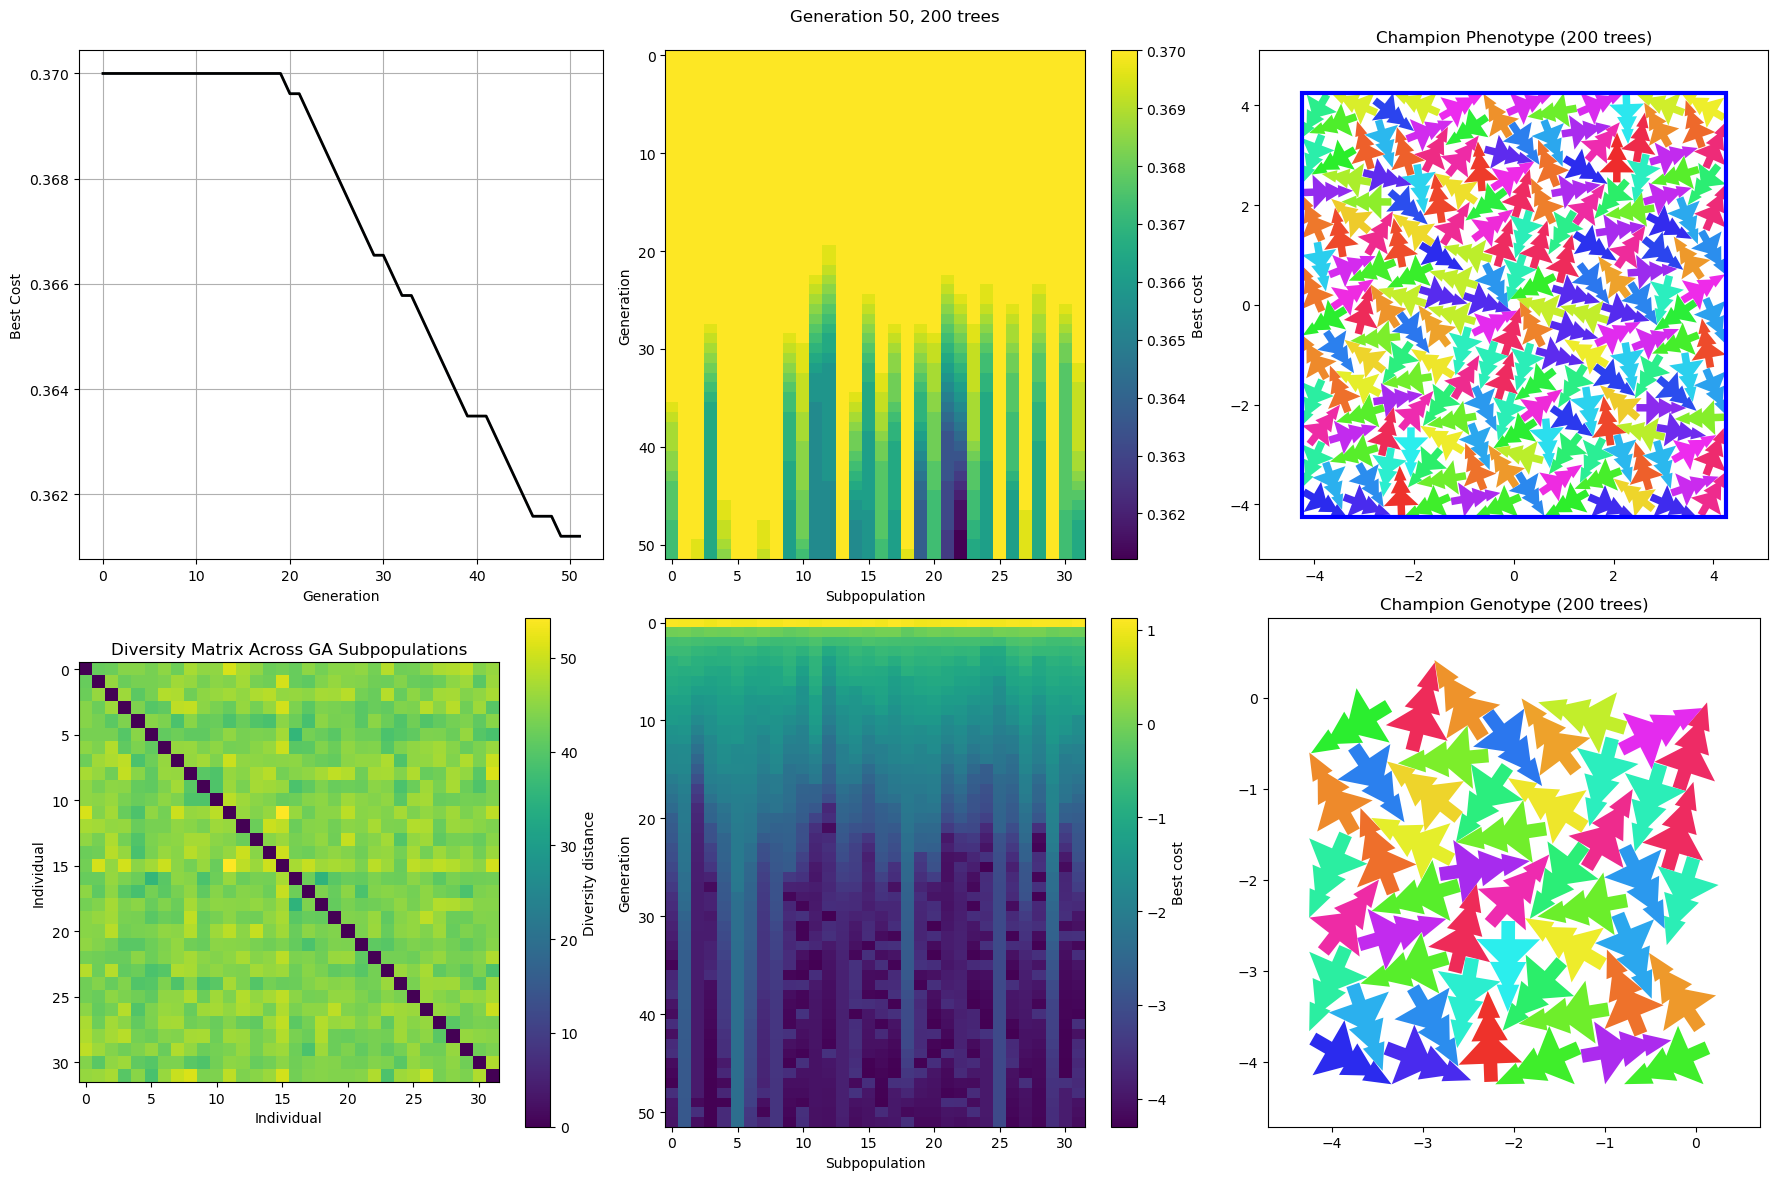

In [ ]:
#%%pyinstrument
#kgs.profiling=True
# %matplotlib widget
#kgs.enable_module_profiling(kgs)
import pack_ga3
import pack_runner
fastMode = False
kgs.debugging_mode = 1

for seed in range(1):

    runner = pack_ga3.baseline()
    runner.ga.ga_base.N_trees_to_do = 200
    runner.diagnostic_plot = True
    runner.seed = seed
    runner.plot_every = 10
    runner.ga.ga_base.initializer.base_solution = kgs.SolutionCollectionSquareSymmetric90()
    #runner.filter_before_rough = 1.

    runner.run()